<a href="https://colab.research.google.com/github/ManoMax/google-collabs/blob/main/(Demo)_Classificacao_de_Texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação de Texto

Implementação de modelos de classificação usando um [Dataset de notícias da BBC](https://www.kaggle.com/competitions/learn-ai-bbc/data).


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Carga dos Dados

--2022-08-02 11:29:31--  https://docs.google.com/uc?export=download&id=1Tzi0ZeO9tFs9P-RmUWjuZtpg7dqjGlv7
Resolving docs.google.com (docs.google.com)... 108.177.120.138, 108.177.120.139, 108.177.120.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.120.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/22vbdbfd4r2aqor5rudc9imfp7tjehg8/1659439725000/12301012272938841923/*/1Tzi0ZeO9tFs9P-RmUWjuZtpg7dqjGlv7?e=download&uuid=1e41096d-dd7f-4679-8a9b-82db88c9270e [following]
--2022-08-02 11:29:34--  https://doc-0o-6g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/22vbdbfd4r2aqor5rudc9imfp7tjehg8/1659439725000/12301012272938841923/*/1Tzi0ZeO9tFs9P-RmUWjuZtpg7dqjGlv7?e=download&uuid=1e41096d-dd7f-4679-8a9b-82db88c9270e
Resolving doc-0o-6g-docs.googleusercontent.com (doc-0o-6g-docs.googleusercontent.com)... 142.251.6.132, 2607:f8

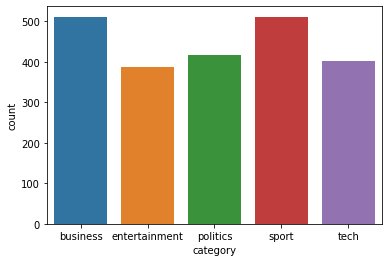

In [ ]:
!wget -O bbc_news.csv "https://docs.google.com/uc?export=download&id=1Tzi0ZeO9tFs9P-RmUWjuZtpg7dqjGlv7"

# Read data frame
df = pd.read_csv('./bbc_news.csv', encoding= 'unicode_escape')

# Description of the dataset
print('SHAPE OF DATASET: ', df.shape, 
      '\n\nCOLUMNS IN DATASET: ', df.columns, 
      '\n\nCATEGORIES: ', df.category.unique(), 
      '\n\nDATA SAMPLE: \n\n', df.sample(n=5), '\n\n')

# Plotting number of samples within each category
print('NUMBER OF SAMPLES IN EACH CATEGORY: \n')
sns.countplot(df.category)

## Pré processamento dos dados

In [ ]:
# DATA CLEANING
print('Data cleaning in progress...')

# Tokenize
df['text_clean'] = df['text'].apply(nltk.word_tokenize)
print('Tokenization complete.')

# Remove stop words
stop_words=set(nltk.corpus.stopwords.words("english"))
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if item not in stop_words])
print('Stop words removed.')

# Remove numbers, punctuation and special characters (only keep words)
regex = '[a-z]+'
df['text_clean'] = df['text_clean'].apply(lambda x: [item for item in x if re.match(regex, item)])
print('Numbers, punctuation and special characters removed.')

# Lemmatization
# Does not take into account the POS-Tagger (for that, it should tokenize by sentence 
# and inform the POS-TAG to the Lemmatizer)
lem = nltk.stem.wordnet.WordNetLemmatizer()
df['text_clean'] = df['text_clean'].apply(lambda x: [lem.lemmatize(item) for item in x])
print('Lemmatization complete.\nData cleaning complete.\n')

Data cleaning in progress...
Tokenization complete.
Stop words removed.
Numbers, punctuation and special characters removed.
Lemmatization complete.
Data cleaning complete.



In [ ]:
print('Before Cleaning:\n\n', df['text'][0:5])
df['text'] = df['text_clean'].apply(lambda x: ' '.join(x))
print('After Cleaning:\n\n', df['text'][0:5])

## Preparação dos dados para treino / teste

### Codificação das Labels

In [ ]:
# Encode label categories to numbers
enc = LabelEncoder()
df['category'] = enc.fit_transform(df['category'])
labels = list(enc.classes_)

In [ ]:
labels

['business', 'entertainment', 'politics', 'sport', 'tech']

In [ ]:
df['category'][600:655]

600    1
601    1
602    1
603    1
604    1
605    1
606    1
607    1
608    1
609    1
610    1
611    1
612    1
613    1
614    1
615    1
616    1
617    1
618    1
619    1
620    1
621    1
622    1
623    1
624    1
625    1
626    1
627    1
628    1
629    1
630    1
631    1
632    1
633    1
634    1
635    1
636    1
637    1
638    1
639    1
640    1
641    1
642    1
643    1
644    1
645    1
646    1
647    1
648    1
649    1
650    1
651    1
652    1
653    1
654    1
Name: category, dtype: int64

Business words:


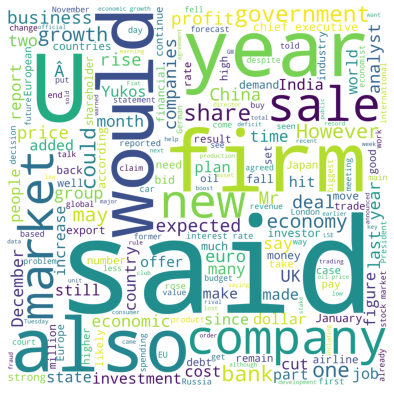

Entertainment words:


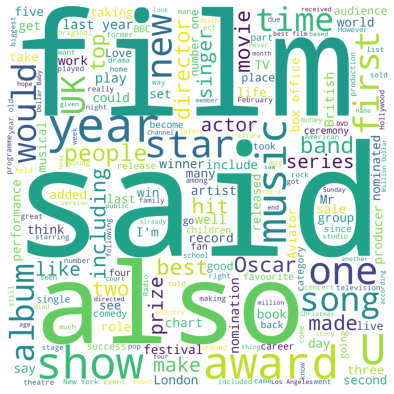

Politics words:


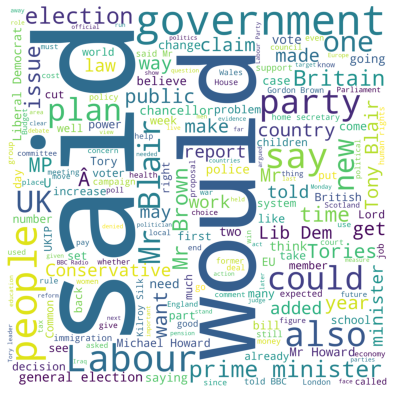

Sport words:


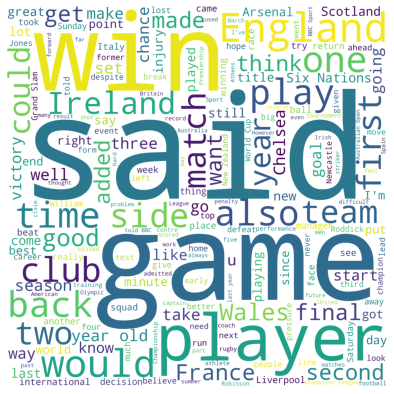

Tech words:


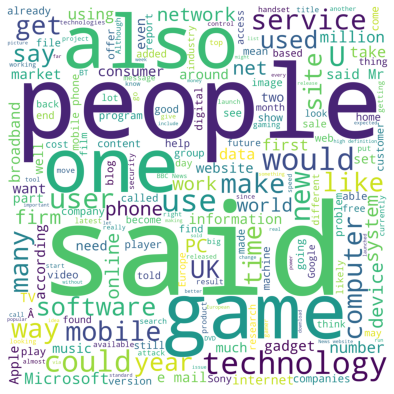

In [ ]:
from wordcloud import WordCloud
from nltk.corpus import stopwords

stop = set(stopwords.words('english'))

business = df[df['category'] == 0]
business = business['text']

entertainment = df[df['category'] == 1]
entertainment = entertainment['text']

politics = df[df['category'] == 2]
politics = politics['text']

sport = df[df['category'] == 3]
sport = sport['text']

tech = df[df['category'] == 4]
tech = tech['text']

def wordcloud_draw(df, color = 'white'):

  words = ' '.join(df)
  cleaned_word = ' '.join([word for word in words.split() if (word != 'news' and word != 'text')])
  wordcloud = WordCloud(stopwords = stop, background_color = color, width = 2500, height = 2500).generate(cleaned_word)
  
  plt.figure(1, figsize = (10,7))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

print("Business words:")
wordcloud_draw(business, 'white')

print("Entertainment words:")
wordcloud_draw(entertainment, 'white')

print("Politics words:")
wordcloud_draw(politics, 'white')

print("Sport words:")
wordcloud_draw(sport, 'white')

print("Tech words:")
wordcloud_draw(tech, 'white')


### Separação dos dados para treino / teste

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, shuffle=True)

In [ ]:
X_train[0:5]

808     Stars pay tribute to actor Davis\n \n Hollywoo...
518     Arnold congratulated on Oscar win\n \n Oscar-w...
1887    Casual gaming to 'take off'\n \n Games aimed a...
1222    Howard and Blair tax pledge clash\n \n Tony Bl...
750     Aaliyah claim dismissed by court\n \n Late R&B...
Name: text, dtype: object

In [ ]:
y_train[0:5]

808     1
518     1
1887    4
1222    2
750     1
Name: category, dtype: int64

### Vetorização com TF-IDF

In [ ]:
vec = TfidfVectorizer()
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

## Treinando um Modelo com Algoritmo Multinomial Naive Bayes

In [ ]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC, LinearSVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neighbors import KNeighborsClassifier

model = MultinomialNB()
model.fit(X_train_vec, y_train)

MultinomialNB()

In [ ]:
print(X_test[0:1], '\n\n\n')
print(X_test_vec[0:1], '\n\n\n')

p = model.predict(X_test_vec[0:1])
print(p)

1039    MPs issued with Blackberry threat\n \n MPs wil...
Name: text, dtype: object 



  (0, 26355)	0.038006034365860315
  (0, 26263)	0.022557953270549762
  (0, 26210)	0.02730014119235352
  (0, 26067)	0.04170708551699822
  (0, 25421)	0.10365037939492097
  (0, 25410)	0.0901886253555832
  (0, 25408)	0.09052328242372831
  (0, 25331)	0.02523482060179045
  (0, 24340)	0.04818205418972484
  (0, 24215)	0.08480244751163549
  (0, 24184)	0.06912906186115612
  (0, 24159)	0.024136603584269403
  (0, 24130)	0.026674806494431574
  (0, 24103)	0.026975485418425597
  (0, 24094)	0.19175674790309694
  (0, 23176)	0.05157353522104153
  (0, 22546)	0.29637660202636007
  (0, 22457)	0.07244708263836787
  (0, 22401)	0.03371571750469719
  (0, 21742)	0.04554447565718426
  (0, 21516)	0.1377626183241423
  (0, 20870)	0.06298626709124365
  (0, 20868)	0.06769708385091355
  (0, 20421)	0.06497501107124239
  (0, 20347)	0.055097748910604184
  :	:
  (0, 5661)	0.08071270155293414
  (0, 5285)	0.07704416419198258
  (0, 5109)	0

In [ ]:
def classify_text(vectorizer, classifier, input_text):
  y_pred1 = vectorizer.transform([input_text])
  yy = classifier.predict(y_pred1)
  result = ""
  if yy == [0]:
    result = "Business News"
  elif yy == [1]:
    result = "Entertainment News"
  elif yy == [2]:
    result = "Politics News"
  elif yy == [3]:
    result = "Sports News"
  elif yy == [4]:
    result = "Tech News"
  print(result)

In [ ]:
sample_text = 'ways to lose your vote'
classify_text(vec, model, sample_text)

Politics News


## Avaliação do Modelo

### Precision, Recall, F1

In [ ]:
y_pred = model.predict(X_test_vec)
print("Precision: %1.3f" % (precision_score(y_test, y_pred, average='macro')))
print("Recall: %1.3f" % (recall_score(y_test, y_pred, average='macro')))
print("F1: %1.3f\n" % (f1_score(y_test, y_pred, average='macro')))

Precision: 0.939
Recall: 0.934
F1: 0.934



In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93        90
           1       1.00      0.79      0.88        84
           2       0.92      0.97      0.95        98
           3       0.96      1.00      0.98       100
           4       0.90      0.97      0.93        73

    accuracy                           0.94       445
   macro avg       0.94      0.93      0.93       445
weighted avg       0.94      0.94      0.94       445



### Matriz de confusão

In [ ]:
from sklearn.metrics import confusion_matrix
 
cm = confusion_matrix(y_test,y_pred)
cm

array([[ 85,   0,   1,   0,   4],
       [  4,  66,   7,   3,   4],
       [  2,   0,  95,   1,   0],
       [  0,   0,   0, 100,   0],
       [  2,   0,   0,   0,  71]])

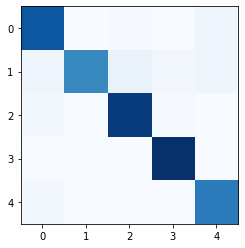

In [ ]:
plt.imshow(cm, cmap='Blues')

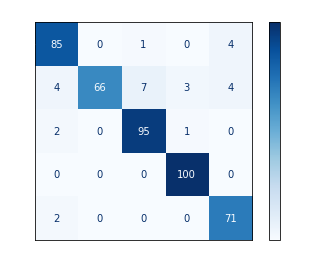

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
 
color = 'white'
matrix = plot_confusion_matrix(model, X_test_vec, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

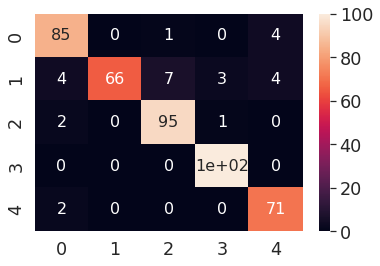

In [ ]:
import seaborn as sn
sn.set(font_scale=1.6) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

## Execução de Múltiplos Algoritmos e Busca por Melhores Parâmetros

### Configuração

In [ ]:
# Use multiple classifiers and grid search for prediction
def ML_modeling(models, params, X_train, X_test, y_train, y_test):    
    
    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
    
        model = models[key]
        param = params[key]
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        
        # Print scores for the classifier
        print(key, ':', gs.best_params_)
        print("Precision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (precision_score(y_test, y_pred, average='macro'), recall_score(y_test, y_pred, average='macro'), f1_score(y_test, y_pred, average='macro')))
    
    return

models = {
    'Naive Bayes': MultinomialNB(), 
    'Decision Tree': DecisionTreeClassifier(),  
    'Perceptron': MLPClassifier()
}

params = {
    'Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] }, 
    'Decision Tree': { 'min_samples_split': [1, 2, 5] }, 
    'Perceptron': { 'alpha': [0.0001, 0.001], 'activation': ['tanh', 'relu'] }
}

### Execução

In [ ]:
ML_modeling(models, params, X_train_vec, X_test_vec, y_train, y_test)

Naive Bayes : {'alpha': 0.5, 'fit_prior': False}
Precision: 0.962 	Recall: 0.960 		F1: 0.960

Decision Tree : {'min_samples_split': 2}
Precision: 0.769 	Recall: 0.769 		F1: 0.768

